In [ ]:
# Instale as bibliotecas necessárias
# pip install pandas sentence-transformers scikit-learn evaluate matplotlib seaborn
# !pip install evaluate
# !pip install rouge-score
import pandas as pd
import nltk
nltk.download('punkt')
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:

# ===========================
# 1. Carregar dados
# ===========================
df = pd.read_csv('6.data_with_summaries.csv')
df = df.dropna(subset=['summary', 'ideal_summary'])
# Verifica se as colunas existem
print(df.columns)

# ===========================
# 2. Selecionar colunas
# ===========================
summaries = df['summary'].astype(str).tolist()
ideal_summaries = df['ideal_summary'].astype(str).tolist()



Index(['video_id', 'title', 'transcription', 'summary', 'ideal_summary'], dtype='object')


In [6]:
# ===========================
# 3. Similaridade Semântica
# ===========================
model = SentenceTransformer('all-MiniLM-L6-v2')

# Gerar embeddings
emb_summaries = model.encode(summaries, convert_to_tensor=False)
emb_ideal = model.encode(ideal_summaries, convert_to_tensor=False)

# Calcular similaridade coseno (linha a linha)
similaridades = [
    cosine_similarity([emb_summaries[i]], [emb_ideal[i]])[0][0]
    for i in range(len(summaries))
]

df['similaridade_cosine'] = similaridades


In [7]:

# ===========================
# 4. ROUGE
# ===========================
rouge = evaluate.load('rouge')

def calc_rouge(pred, ref):
    result = rouge.compute(predictions=[pred], references=[ref])
    return result['rouge1'], result['rouge2'], result['rougeL'], result['rougeLsum']

# Aplicar no dataframe
df[['rouge1', 'rouge2', 'rougeL', 'rougeLsum']] = df.apply(
    lambda row: pd.Series(calc_rouge(row['summary'], row['ideal_summary'])),
    axis=1
)




===== Estatísticas =====
Média Similaridade Cosine: 0.7274
Média ROUGE-1: 0.4365
Média ROUGE-2: 0.1959
Média ROUGE-L: 0.2927
Média ROUGE-Lsum: 0.2927


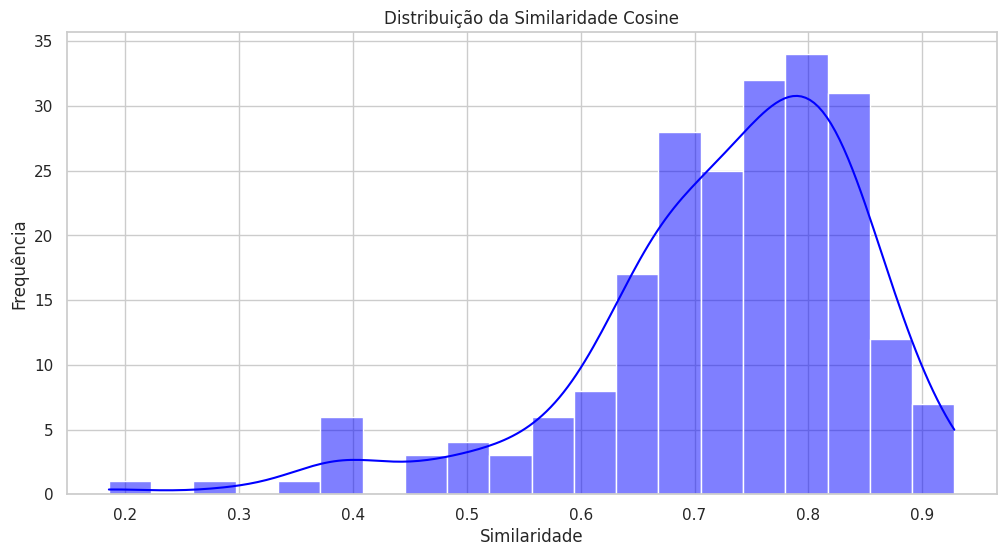

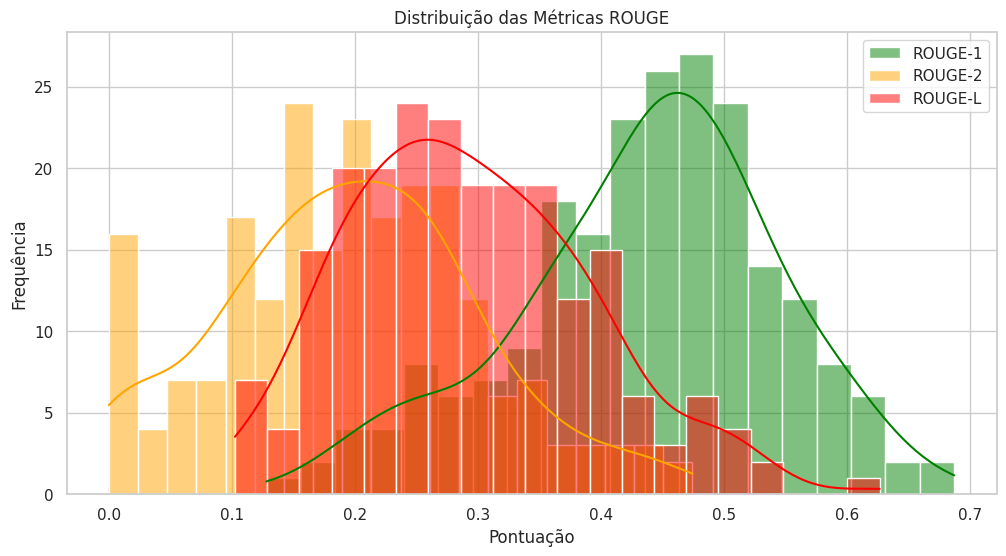

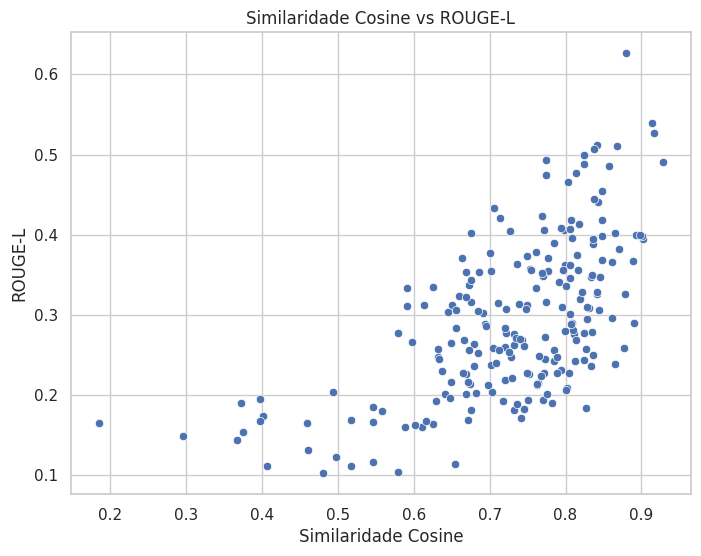

In [8]:
# ===========================
# 5. Estatísticas Descritivas
# ===========================
print("\n===== Estatísticas =====")
print(f"Média Similaridade Cosine: {df['similaridade_cosine'].mean():.4f}")
print(f"Média ROUGE-1: {df['rouge1'].mean():.4f}")
print(f"Média ROUGE-2: {df['rouge2'].mean():.4f}")
print(f"Média ROUGE-L: {df['rougeL'].mean():.4f}")
print(f"Média ROUGE-Lsum: {df['rougeLsum'].mean():.4f}")

# ===========================
# 6. Visualização dos Resultados
# ===========================

# Configurações do estilo dos gráficos
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(df['similaridade_cosine'], bins=20, kde=True, color='blue')
plt.title('Distribuição da Similaridade Cosine')
plt.xlabel('Similaridade')
plt.ylabel('Frequência')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df['rouge1'], bins=20, kde=True, color='green', label='ROUGE-1')
sns.histplot(df['rouge2'], bins=20, kde=True, color='orange', label='ROUGE-2')
sns.histplot(df['rougeL'], bins=20, kde=True, color='red', label='ROUGE-L')
plt.title('Distribuição das Métricas ROUGE')
plt.xlabel('Pontuação')
plt.ylabel('Frequência')
plt.legend()
plt.show()

# Correlação entre Similaridade e ROUGE
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='similaridade_cosine', y='rougeL')
plt.title('Similaridade Cosine vs ROUGE-L')
plt.xlabel('Similaridade Cosine')
plt.ylabel('ROUGE-L')
plt.show()

In [9]:
# Ordena o dataframe pela coluna de similaridade do cosseno em ordem decrescente
top3 = df.sort_values(by='similaridade_cosine', ascending=False).head(3)

# Exibe os 3 melhores
print(top3[['summary', 'ideal_summary', 'similaridade_cosine']])

                                               summary  \
133  O ex-governador do Rio de Janeiro, Sérgio Cabr...   
87   O Rio de Janeiro deu as boas-vindas a 2022 com...   
84   Uma sucuri de quase quatro metros foi capturad...   

                                         ideal_summary  similaridade_cosine  
133  O ex-governador do Rio de Janeiro sérgio cabra...             0.928181  
87   Rio de janeiro 2022 foi recebido com tradicion...             0.916369  
84   A sucuri de quase quatro metros foi capturada ...             0.914166  
